In [1]:
!pip install polars --no-index --find-links=file:///kaggle/input/polars-and-duckdb/kaggle/working/mysitepackages/polars_pkg

Looking in links: file:///kaggle/input/polars-and-duckdb/kaggle/working/mysitepackages/polars_pkg
Processing /kaggle/input/polars-and-duckdb/kaggle/working/mysitepackages/polars_pkg/polars-0.20.16-cp38-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import glob
import os
import polars as pl
#import duckdb as dd
#from tqdm import tqdm
import matplotlib.pyplot as plt
#import cv2
#from pydicom import dcmread
import warnings
#from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
import pickle
#import gc
import ctypes
import tensorflow as tf
import tensorflow_io as tfio
from tensorflow import keras

E0000 00:00:1728034305.090770      13 common_lib.cc:798] Could not set metric server port: INVALID_ARGUMENT: Could not find SliceBuilder port 8471 in any of the 0 ports provided in `tpu_process_addresses`="local"
=== Source Location Trace: ===
learning/45eac/tfrc/runtime/common_lib.cc:479
D1004 09:31:45.099119473      13 config.cc:196]                        gRPC EXPERIMENT call_status_override_on_cancellation   OFF (default:OFF)
D1004 09:31:45.099133183      13 config.cc:196]                        gRPC EXPERIMENT call_v3                                OFF (default:OFF)
D1004 09:31:45.099136392      13 config.cc:196]                        gRPC EXPERIMENT canary_client_privacy                  ON  (default:ON)
D1004 09:31:45.099138746      13 config.cc:196]                        gRPC EXPERIMENT capture_base_context                   ON  (default:ON)
D1004 09:31:45.099141124      13 config.cc:196]                        gRPC EXPERIMENT client_idleness                        ON  (defau

In [3]:
# detect TPUs
tpu = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='local')
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.TPUStrategy(tpu)

print("Number of accelerators: ", tpu_strategy.num_replicas_in_sync)

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.
INFO:tensorflow:Initializing the TPU system: local


I0000 00:00:1728034340.748624      13 service.cc:145] XLA service 0x58c7f1883000 initialized for platform TPU (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1728034340.748671      13 service.cc:153]   StreamExecutor device (0): TPU, 2a886c8
I0000 00:00:1728034340.748675      13 service.cc:153]   StreamExecutor device (1): TPU, 2a886c8
I0000 00:00:1728034340.748678      13 service.cc:153]   StreamExecutor device (2): TPU, 2a886c8
I0000 00:00:1728034340.748681      13 service.cc:153]   StreamExecutor device (3): TPU, 2a886c8
I0000 00:00:1728034340.748683      13 service.cc:153]   StreamExecutor device (4): TPU, 2a886c8
I0000 00:00:1728034340.748685      13 service.cc:153]   StreamExecutor device (5): TPU, 2a886c8
I0000 00:00:1728034340.748687      13 service.cc:153]   StreamExecutor device (6): TPU, 2a886c8
I0000 00:00:1728034340.748690      13 service.cc:153]   StreamExecutor device (7): TPU, 2a886c8


INFO:tensorflow:Finished initializing TPU system.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)
I

In [4]:
def read_and_parse_dicom_files_tensorflow_train(full_file_path):
    #tf.config.run_functions_eagerly(True)
    raw_image = tf.io.read_file(full_file_path)
    sp = tf.strings.split(tf.gather(tf.strings.split(full_file_path, 'images/'), 1), '/')
    N = tf.size(sp)
    LEN = tf.strings.length(tf.gather(sp, 0))+tf.strings.length(tf.gather(sp, 2))
    
    # Add missing file metadata to avoid warnnigs flooding
    if   LEN==12: raw_image = tf.strings.regex_replace(raw_image, pattern=b'DICM\x02\x00\x01\x00', rewrite=b'DICM\x02\x00\x00\x00UL\x04\x00\x92\x00\x00\x00\x02\x00\x01\x00')
    elif LEN==13: raw_image = tf.strings.regex_replace(raw_image, pattern=b'DICM\x02\x00\x01\x00', rewrite=b'DICM\x02\x00\x00\x00UL\x04\x00\x92\x00\x00\x00\x02\x00\x01\x00')
    elif LEN==14: raw_image = tf.strings.regex_replace(raw_image, pattern=b'DICM\x02\x00\x01\x00', rewrite=b'DICM\x02\x00\x00\x00UL\x04\x00\x94\x00\x00\x00\x02\x00\x01\x00')
    elif LEN==15: raw_image = tf.strings.regex_replace(raw_image, pattern=b'DICM\x02\x00\x01\x00', rewrite=b'DICM\x02\x00\x00\x00UL\x04\x00\x94\x00\x00\x00\x02\x00\x01\x00')
    elif LEN==16: raw_image = tf.strings.regex_replace(raw_image, pattern=b'DICM\x02\x00\x01\x00', rewrite=b'DICM\x02\x00\x00\x00UL\x04\x00\x96\x00\x00\x00\x02\x00\x01\x00')
    elif LEN==17: raw_image = tf.strings.regex_replace(raw_image, pattern=b'DICM\x02\x00\x01\x00', rewrite=b'DICM\x02\x00\x00\x00UL\x04\x00\x96\x00\x00\x00\x02\x00\x01\x00')
    elif LEN==18: raw_image = tf.strings.regex_replace(raw_image, pattern=b'DICM\x02\x00\x01\x00', rewrite=b'DICM\x02\x00\x00\x00UL\x04\x00\x98\x00\x00\x00\x02\x00\x01\x00')
    
    image = tfio.image.decode_dicom_image(raw_image, scale='auto', dtype=tf.float32)
    m, M=tf.math.reduce_min(image), tf.math.reduce_max(image)
    image = (tf.image.grayscale_to_rgb(image)-m)/(M-m)
    image = tf.image.resize(image, (128,128))
    sqzd_image = tf.squeeze(image)
    #shaped_image = sqzd_image.set_shape(sqzd_image.get_shape())
    return sqzd_image

def read_parse_n_augment_dicom_files(full_file_path):
    #tf.config.run_functions_eagerly(True)
    raw_image = tf.io.read_file(full_file_path)
    sp = tf.strings.split(tf.gather(tf.strings.split(full_file_path, 'images/'), 1), '/')
    N = tf.size(sp)
    LEN = tf.strings.length(tf.gather(sp, 0))+tf.strings.length(tf.gather(sp, 2))
    
    # Add missing file metadata to avoid warnnigs flooding
    if   LEN==12: raw_image = tf.strings.regex_replace(raw_image, pattern=b'DICM\x02\x00\x01\x00', rewrite=b'DICM\x02\x00\x00\x00UL\x04\x00\x92\x00\x00\x00\x02\x00\x01\x00')
    elif LEN==13: raw_image = tf.strings.regex_replace(raw_image, pattern=b'DICM\x02\x00\x01\x00', rewrite=b'DICM\x02\x00\x00\x00UL\x04\x00\x92\x00\x00\x00\x02\x00\x01\x00')
    elif LEN==14: raw_image = tf.strings.regex_replace(raw_image, pattern=b'DICM\x02\x00\x01\x00', rewrite=b'DICM\x02\x00\x00\x00UL\x04\x00\x94\x00\x00\x00\x02\x00\x01\x00')
    elif LEN==15: raw_image = tf.strings.regex_replace(raw_image, pattern=b'DICM\x02\x00\x01\x00', rewrite=b'DICM\x02\x00\x00\x00UL\x04\x00\x94\x00\x00\x00\x02\x00\x01\x00')
    elif LEN==16: raw_image = tf.strings.regex_replace(raw_image, pattern=b'DICM\x02\x00\x01\x00', rewrite=b'DICM\x02\x00\x00\x00UL\x04\x00\x96\x00\x00\x00\x02\x00\x01\x00')
    elif LEN==17: raw_image = tf.strings.regex_replace(raw_image, pattern=b'DICM\x02\x00\x01\x00', rewrite=b'DICM\x02\x00\x00\x00UL\x04\x00\x96\x00\x00\x00\x02\x00\x01\x00')
    elif LEN==18: raw_image = tf.strings.regex_replace(raw_image, pattern=b'DICM\x02\x00\x01\x00', rewrite=b'DICM\x02\x00\x00\x00UL\x04\x00\x98\x00\x00\x00\x02\x00\x01\x00')
    
    image = tfio.image.decode_dicom_image(raw_image, scale='auto', dtype=tf.float32)
    m, M=tf.math.reduce_min(image), tf.math.reduce_max(image)
    image = (tf.image.grayscale_to_rgb(image)-m)/(M-m)
    
    brt_image = tf.image.adjust_brightness(image, delta=0.3)
    contrast_img = tf.image.adjust_contrast(brt_image, contrast_factor=2.0)
    contrast_img_resized = tf.image.resize(contrast_img, (128,128))

    return tf.squeeze(contrast_img_resized)

def preprocessing_aug_image(img_path):
    train_img = read_parse_n_augment_dicom_files(img_path)
    train_img = tf.reshape(train_img, shape=(128, 128, 3))
    return train_img

def load_aug_dataset(image_path, labels):
    image = preprocessing_aug_image(image_path)
    return {"images": tf.cast(image, tf.float32), "labels": tf.cast(labels, tf.float32)}

def preprocessing(img_path):
    train_img = read_and_parse_dicom_files_tensorflow_train(img_path)
    train_img = tf.reshape(train_img, shape=(128, 128, 3))
    return train_img

def load_dataset_tensorflow_train(image_path, labels):
    image = preprocessing(image_path)
    return {"images": tf.cast(image, tf.float32), "labels": tf.cast(labels, tf.float32)}

def dict_to_tuple(inputs):
    return inputs["images"], inputs["labels"]

In [5]:
condition_for_training = 'right_subarticular_stenosis'
vertebrae_position = 'l1_l2'

metadata_file_path = '/kaggle/input/right-subarticular-stenosis-metadata/{0}_{1}_feature_metadata.csv'.format(condition_for_training, vertebrae_position)
metadata_df = pl.read_csv(metadata_file_path, low_memory=True)

metadata_df_severe = metadata_df.filter(pl.col('encoded_severity')==2)
metadata_df_moderate = metadata_df.filter(pl.col('encoded_severity')==0)
metadata_df_normal_mild = metadata_df.filter(pl.col('encoded_severity')==1)

x_train, x_test_val = train_test_split(metadata_df, test_size=0.4, random_state=42)
x_test, x_valid = train_test_split(x_test_val, test_size=0.2, random_state=42)

print("Training data shape : {0}".format(x_train.shape))
print("Test data shape : {0}".format(x_test.shape))
print("Validation data shape : {0}".format(x_valid.shape))
print("metadata_df_severe shape : {0}".format(metadata_df_severe.shape))
print("metadata_df_moderate shape : {0}".format(metadata_df_moderate.shape))
print("metadata_df_normal_mild shape : {0}".format(metadata_df_normal_mild.shape))

Training data shape : (83053, 3)
Test data shape : (44295, 3)
Validation data shape : (11074, 3)
metadata_df_severe shape : (1956, 3)
metadata_df_moderate shape : (8752, 3)
metadata_df_normal_mild shape : (127714, 3)


In [6]:
x_train.columns

['full_img_path', 'severity', 'encoded_severity']

In [8]:
x_train.group_by(["encoded_severity","severity"]).agg(pl.col("full_img_path").count())

encoded_severity,severity,full_img_path
i64,str,u32
0,"""Moderate""",5206
2,"""Severe""",1171
1,"""Normal/Mild""",76676


In [9]:
x_test.group_by(["encoded_severity","severity"]).agg(pl.col("full_img_path").count())

encoded_severity,severity,full_img_path
i64,str,u32
0,"""Moderate""",2853
1,"""Normal/Mild""",40802
2,"""Severe""",640


In [10]:
x_valid.group_by(["encoded_severity","severity"]).agg(pl.col("full_img_path").count())

encoded_severity,severity,full_img_path
i64,str,u32
0,"""Moderate""",693
1,"""Normal/Mild""",10236
2,"""Severe""",145


In [11]:
def generate_tf_datasets(p_train_df, p_test_df, p_valid_df, p_BATCH_SIZE_PER_REPLICA):

    BATCH_SIZE = p_BATCH_SIZE_PER_REPLICA * tpu_strategy.num_replicas_in_sync
    
    train_image_filenames = pl.Series(p_train_df.select(pl.col('full_img_path'))).to_list()
    train_image_labels = pl.Series(p_train_df.select(pl.col('encoded_severity'))).to_list()

    test_image_filenames = pl.Series(p_test_df.select(pl.col('full_img_path'))).to_list()
    test_image_labels = pl.Series(p_test_df.select(pl.col('encoded_severity'))).to_list()

    valid_image_filenames = pl.Series(p_valid_df.select(pl.col('full_img_path'))).to_list()
    valid_image_labels = pl.Series(p_valid_df.select(pl.col('encoded_severity'))).to_list()
    
    train_dataset = tf.data.Dataset.from_tensor_slices((train_image_filenames, train_image_labels))
    test_dataset = tf.data.Dataset.from_tensor_slices((test_image_filenames, test_image_labels))
    valid_dataset = tf.data.Dataset.from_tensor_slices((valid_image_filenames, valid_image_labels))
    
    train_ds = train_dataset.map(load_dataset_tensorflow_train, num_parallel_calls=tf.data.AUTOTUNE)
    train_ds = train_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
    train_ds = train_ds.batch(batch_size=BATCH_SIZE, drop_remainder=True)
    train_ds = train_ds.prefetch(tf.data.AUTOTUNE)

    test_ds = test_dataset.map(load_dataset_tensorflow_train, num_parallel_calls=tf.data.AUTOTUNE)
    test_ds = test_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
    test_ds = test_ds.batch(batch_size=BATCH_SIZE, drop_remainder=True)
    test_ds = test_ds.prefetch(tf.data.AUTOTUNE)

    valid_ds = valid_dataset.map(load_dataset_tensorflow_train, num_parallel_calls=tf.data.AUTOTUNE)
    valid_ds = valid_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
    valid_ds = valid_ds.batch(batch_size=BATCH_SIZE, drop_remainder=True)
    valid_ds = valid_ds.prefetch(tf.data.AUTOTUNE)
    
    return train_ds, test_ds, valid_ds

In [12]:
train_ds, test_ds, valid_ds = generate_tf_datasets(p_train_df=x_train, p_test_df=x_test, p_valid_df=x_valid
                                                   , p_BATCH_SIZE_PER_REPLICA = 16)

BATCH_SIZE = 16 * tpu_strategy.num_replicas_in_sync

metadata_df_severe_filenames = pl.Series(metadata_df_severe.select(pl.col('full_img_path'))).to_list()
metadata_df_severe_labels = pl.Series(metadata_df_severe.select(pl.col('encoded_severity'))).to_list()

metadata_df_moderate_filenames = pl.Series(metadata_df_moderate.select(pl.col('full_img_path'))).to_list()
metadata_df_moderate_labels = pl.Series(metadata_df_moderate.select(pl.col('encoded_severity'))).to_list()

metadata_df_severe_dataset = tf.data.Dataset.from_tensor_slices((metadata_df_severe_filenames, metadata_df_severe_labels))
metadata_df_moderate_dataset = tf.data.Dataset.from_tensor_slices((metadata_df_moderate_filenames, metadata_df_moderate_labels))

metadata_df_severe_ds = metadata_df_severe_dataset.map(load_aug_dataset, num_parallel_calls=tf.data.AUTOTUNE)
metadata_df_severe_ds = metadata_df_severe_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
metadata_df_severe_ds = metadata_df_severe_ds.batch(batch_size=BATCH_SIZE, drop_remainder=True)
metadata_df_severe_ds = metadata_df_severe_ds.prefetch(tf.data.AUTOTUNE)

metadata_df_severe_ds = metadata_df_severe_dataset.map(load_aug_dataset, num_parallel_calls=tf.data.AUTOTUNE)
metadata_df_severe_ds = metadata_df_severe_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
metadata_df_severe_ds = metadata_df_severe_ds.batch(batch_size=BATCH_SIZE, drop_remainder=True)
metadata_df_severe_ds = metadata_df_severe_ds.prefetch(tf.data.AUTOTUNE)

metadata_df_moderate_ds = metadata_df_moderate_dataset.map(load_aug_dataset, num_parallel_calls=tf.data.AUTOTUNE)
metadata_df_moderate_ds = metadata_df_moderate_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
metadata_df_moderate_ds = metadata_df_moderate_ds.batch(batch_size=BATCH_SIZE, drop_remainder=True)
metadata_df_moderate_ds = metadata_df_moderate_ds.prefetch(tf.data.AUTOTUNE)

severe_plus_moderate_augd = metadata_df_severe_ds.concatenate(metadata_df_moderate_ds)

combined_train_dataset = train_ds.concatenate(severe_plus_moderate_augd)

In [12]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers

with tpu_strategy.scope():
    
    rsna_input = layers.Input(shape=(128,128,3), name="rsna_input")

    conv_base = EfficientNetB0(include_top=False, weights="imagenet", input_tensor=rsna_input)
    conv_base.trainable = False

    max_pool_layer_0 = layers.MaxPooling2D(name="max_pool_0", pool_size=(2, 2), strides=(1, 1), padding="same")(conv_base.output)
    max_pool_layer_0 = layers.BatchNormalization()(max_pool_layer_0)

    conv2d_1 = layers.Conv2D(filters=100, kernel_size=4, strides=1, padding="same", activation="relu")(max_pool_layer_0)
    max_pool_layer_1 = layers.MaxPooling2D(name="max_pool_1", pool_size=(2, 2), strides=(1, 1), padding="same")(conv2d_1)
    max_pool_layer_1 = layers.BatchNormalization()(max_pool_layer_1)

    flattened_layer = layers.Flatten()(max_pool_layer_1)

    hidden_layer1 = layers.Dense(200, activation="selu", kernel_initializer=keras.initializers.LecunNormal(seed=None))(flattened_layer)
    hidden_layer1 = layers.BatchNormalization()(hidden_layer1)
    hidden_layer2 = layers.Dense(100, activation="selu", kernel_initializer=keras.initializers.LecunNormal(seed=None))(hidden_layer1)
    hidden_layer2 = layers.BatchNormalization()(hidden_layer2)
    hidden_layer3 = layers.Dense(50, activation="selu", kernel_initializer=keras.initializers.LecunNormal(seed=None))(hidden_layer2)
    hidden_layer3 = layers.BatchNormalization()(hidden_layer3)
    rsna_output = layers.Dense(3, activation="softmax")(hidden_layer3)
    model1 = tf.keras.Model(rsna_input, rsna_output)

    checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("keras_effnet_{0}_{1}.keras".format(condition_for_training, vertebrae_position))
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
    """lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=1e-4, decay_steps=100, decay_rate=0.9)
    adamax_optimizer = tf.keras.optimizers.Adamax(learning_rate=lr_schedule)"""

    model1.compile(loss="sparse_categorical_crossentropy", optimizer="adamax", metrics=["accuracy"])
    # model.compile(loss="sparse_categorical_crossentropy", optimizer=adamax_optimizer, metrics=["accuracy"])

In [13]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers

with tpu_strategy.scope():
    
    rsna_input = layers.Input(shape=(128,128,3), name="rsna_input")

    conv_base = EfficientNetB0(include_top=False, weights="imagenet", input_tensor=rsna_input)
    conv_base.trainable = False
    
    conv2d_1 = layers.Conv2D(filters=64, kernel_size=7, strides=2, padding="same", activation="relu")(conv_base.output)
    max_pool_layer_1 = layers.MaxPooling2D(name="max_pool_1", pool_size=(3, 3), strides=(2, 2), padding="same")(conv2d_1)
    """lrn_layer_1 = layers.Lambda(lambda X: tf.nn.local_response_normalization(X), output_shape=(32, 32, 64))(max_pool_layer_1)"""
    max_pool_layer_1 = layers.BatchNormalization()(max_pool_layer_1)
    conv2d_2 = layers.Conv2D(filters=64, kernel_size=1, strides=1, padding="same", activation="relu")(max_pool_layer_1)
    conv2d_3 = layers.Conv2D(filters=192, kernel_size=3, strides=1, padding="same", activation="relu")(conv2d_2)
    # lrn_layer_2 = layers.Lambda(lambda X: tf.nn.local_response_normalization(X))(conv2d_3)
    conv2d_3 = layers.BatchNormalization()(conv2d_3)
    max_pool_layer_2 = layers.MaxPooling2D(name="max_pool_2", pool_size=(3, 3), strides=(2, 2), padding="same")(conv2d_3)
    
    ## Inception layer 1
    conv2d_incpl_1_1 = layers.Conv2D(filters=64, kernel_size=(1, 1), strides=1, padding="same", activation="relu")(max_pool_layer_2)
    conv2d_incpl_1_2 = layers.Conv2D(filters=128, kernel_size=(1, 1), strides=1, padding="same", activation="relu")(max_pool_layer_2)
    max_pool_layer_incpl_1 = layers.MaxPooling2D(name="max_pool_incpl_1", pool_size=(3, 3), strides=(1, 1), padding="same")(max_pool_layer_2)
    conv2d_incpl_1_3 = layers.Conv2D(filters=32, kernel_size=(1, 1), strides=1, padding="same", activation="relu")(max_pool_layer_2)
    conv2d_incpl_1_4 = layers.Conv2D(filters=32, kernel_size=(3, 3), strides=1, padding="same", activation="relu")(conv2d_incpl_1_1)
    conv2d_incpl_1_5 = layers.Conv2D(filters=96, kernel_size=(5, 5), strides=1, padding="same", activation="relu")(conv2d_incpl_1_2)
    conv2d_incpl_1_6 = layers.Conv2D(filters=16, kernel_size=(1, 1), strides=1, padding="same", activation="relu")(max_pool_layer_incpl_1)
    concat_incpl_1 = layers.Concatenate(axis=3)([conv2d_incpl_1_3, conv2d_incpl_1_4, conv2d_incpl_1_5, conv2d_incpl_1_6])
    
    ## Inception layer 2
    conv2d_incpl_2_1 = layers.Conv2D(filters=128, kernel_size=(1, 1), strides=1, padding="same", activation="relu")(concat_incpl_1)
    conv2d_incpl_2_2 = layers.Conv2D(filters=192, kernel_size=(1, 1), strides=1, padding="same", activation="relu")(concat_incpl_1)
    max_pool_layer_incpl_2 = layers.MaxPooling2D(name="max_pool_incpl_2", pool_size=(3, 3), strides=(1, 1), padding="same")(concat_incpl_1)
    conv2d_incpl_2_3 = layers.Conv2D(filters=96, kernel_size=(1, 1), strides=1, padding="same", activation="relu")(concat_incpl_1)
    conv2d_incpl_2_4 = layers.Conv2D(filters=64, kernel_size=(3, 3), strides=1, padding="same", activation="relu")(conv2d_incpl_2_1)
    conv2d_incpl_2_5 = layers.Conv2D(filters=128, kernel_size=(5, 5), strides=1, padding="same", activation="relu")(conv2d_incpl_2_2)
    conv2d_incpl_2_6 = layers.Conv2D(filters=32, kernel_size=(1, 1), strides=1, padding="same", activation="relu")(max_pool_layer_incpl_2)
    concat_incpl_2 = layers.Concatenate(axis=3)([conv2d_incpl_2_3, conv2d_incpl_2_4, conv2d_incpl_2_5, conv2d_incpl_2_6])
    
    max_pool_layer_3 = layers.MaxPooling2D(name="max_pool_3", pool_size=(3, 3), strides=(2, 2), padding="same")(concat_incpl_2)
    
    ## Inception layer 3
    conv2d_incpl_3_1 = layers.Conv2D(filters=192, kernel_size=(1, 1), strides=1, padding="same", activation="relu")(max_pool_layer_3)
    conv2d_incpl_3_2 = layers.Conv2D(filters=208, kernel_size=(1, 1), strides=1, padding="same", activation="relu")(max_pool_layer_3)
    max_pool_layer_incpl_3 = layers.MaxPooling2D(name="max_pool_incpl_3", pool_size=(3, 3), strides=(1, 1), padding="same")(max_pool_layer_3)
    conv2d_incpl_3_3 = layers.Conv2D(filters=48, kernel_size=(1, 1), strides=1, padding="same", activation="relu")(max_pool_layer_3)
    conv2d_incpl_3_4 = layers.Conv2D(filters=64, kernel_size=(3, 3), strides=1, padding="same", activation="relu")(conv2d_incpl_3_1)
    conv2d_incpl_3_5 = layers.Conv2D(filters=96, kernel_size=(5, 5), strides=1, padding="same", activation="relu")(conv2d_incpl_3_2)
    conv2d_incpl_3_6 = layers.Conv2D(filters=16, kernel_size=(1, 1), strides=1, padding="same", activation="relu")(max_pool_layer_incpl_3)
    concat_incpl_3 = layers.Concatenate(axis=3)([conv2d_incpl_3_3, conv2d_incpl_3_4, conv2d_incpl_3_5, conv2d_incpl_3_6])
    
    dropout_1 = layers.Dropout(0.25)
    
    glb_avgp_layer = layers.GlobalAvgPool2D()(concat_incpl_3)
    
    hidden_layer1 = layers.Dense(1000, activation="relu")(glb_avgp_layer)
    
    flattened_layer = layers.Flatten()(hidden_layer1)
    rsna_output = layers.Dense(3, activation="softmax")(flattened_layer)
    model2 = tf.keras.Model(rsna_input, rsna_output)

    checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("keras_effnet_{0}_{1}.keras".format(condition_for_training, vertebrae_position))
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
    """lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=1e-4, decay_steps=100, decay_rate=0.9)
    adamax_optimizer = tf.keras.optimizers.Adamax(learning_rate=lr_schedule)"""

    model2.compile(loss="sparse_categorical_crossentropy", optimizer="adamax", metrics=["accuracy"])
    # model.compile(loss="sparse_categorical_crossentropy", optimizer=adamax_optimizer, metrics=["accuracy"])

I0000 00:00:1728034902.653834      13 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [23]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ rsna_input          │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 64, 64,    │      9,472 │ rsna_input[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pool_1          │ (None, 32, 32,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 32, 32,    │        256 │ max_pool_1[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 32, 32,    │      4,160 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 32, 32,    │    110,784 │ conv2d_1[0][0]    │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        768 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pool_2          │ (None, 16, 16,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 16, 16,    │     12,352 │ max_pool_2[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 16, 16,    │     24,704 │ max_pool_2[0][0]  │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pool_incpl_1    │ (None, 16, 16,    │          0 │ max_pool_2[0][0]  │
│ (MaxPooling2D)      │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 16, 16,    │      6,176 │ max_pool_2[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 16, 16,    │     18,464 │ conv2d_3[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 16, 16,    │    307,296 │ conv2d_4[0][0]    │
│                     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 16, 16,    │      3,088 │ max_pool_incpl_1… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 16, 16,    │          0 │ conv2d_5[0][0],   │
│ (Concatenate)       │ 176)              │            │ conv2d_6[0][0],   │
│                     │                   │            │ conv2d_7[0][0],   │
│                     │                   │            │ conv2d_8[0][0]  

 Total params: 2,441,035 (9.31 MB)

 Trainable params: 2,440,523 (9.31 MB)

 Non-trainable params: 512 (2.00 KB)

In [14]:
with tpu_strategy.scope():
    tf.config.run_functions_eagerly(False)
    history1 = model1.fit(train_ds, class_weight={0:2, 1:1, 2:4}, epochs=22, validation_data=valid_ds
                        , callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/22


2024-10-04 04:38:02.834459: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node StatefulPartitionedCall.
I0000 00:00:1728016683.766466     839 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(d4fd7d2393d2b05c:0:0), session_name()


  1/688 ━━━━━━━━━━━━━━━━━━━━ 4:51:54 25s/step - accuracy: 0.5000 - loss: 2.1715

I0000 00:00:1728016702.096446     839 tpu_compile_op_common.cc:245] Compilation of d4fd7d2393d2b05c:0:0 with session name  took 18.329941801s and succeeded
I0000 00:00:1728016702.169635     839 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(d4fd7d2393d2b05c:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_371961640508795447", property.function_library_fingerprint = 6993542618203642593, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1728016702.169702     839 tpu_compilation_cache_interface.cc:541] After adding entry for key d4fd7d2393d2b05c:0:0

688/688 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.5927 - loss: 1.6539

I0000 00:00:1728016735.743026     834 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(ac4dc420d2f4d3fb:0:0), session_name()
I0000 00:00:1728016739.624059     834 tpu_compile_op_common.cc:245] Compilation of ac4dc420d2f4d3fb:0:0 with session name  took 3.880967187s and succeeded
I0000 00:00:1728016739.640119     834 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(ac4dc420d2f4d3fb:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_17041026798313521525", property.function_library_fingerprint = 7700468813093443529, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "", property.guaranteed_constants_size = 0, embedding_partitions_fi

688/688 ━━━━━━━━━━━━━━━━━━━━ 68s 62ms/step - accuracy: 0.5927 - loss: 1.6539 - val_accuracy: 0.6751 - val_loss: 0.8713
Epoch 2/22
688/688 ━━━━━━━━━━━━━━━━━━━━ 33s 47ms/step - accuracy: 0.6870 - loss: 1.5954 - val_accuracy: 0.6751 - val_loss: 0.9264
Epoch 3/22
688/688 ━━━━━━━━━━━━━━━━━━━━ 34s 47ms/step - accuracy: 0.6894 - loss: 1.5992 - val_accuracy: 0.6751 - val_loss: 0.9704
Epoch 4/22
688/688 ━━━━━━━━━━━━━━━━━━━━ 33s 47ms/step - accuracy: 0.6919 - loss: 1.5976 - val_accuracy: 0.6751 - val_loss: 0.9269
Epoch 5/22
688/688 ━━━━━━━━━━━━━━━━━━━━ 34s 48ms/step - accuracy: 0.6935 - loss: 1.5968 - val_accuracy: 0.6751 - val_loss: 0.9558
Epoch 6/22
688/688 ━━━━━━━━━━━━━━━━━━━━ 33s 47ms/step - accuracy: 0.6908 - loss: 1.5952 - val_accuracy: 0.6751 - val_loss: 0.9076


In [14]:
with tpu_strategy.scope():
    tf.config.run_functions_eagerly(False)
    history2 = model2.fit(train_ds, class_weight={0:2, 1:1, 2:4}, epochs=21, validation_data=valid_ds
                        , callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/21


2024-10-04 09:42:38.575566: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node StatefulPartitionedCall.
I0000 00:00:1728034959.719652     835 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(f4dbe6622b495783:0:0), session_name()


  1/648 ━━━━━━━━━━━━━━━━━━━━ 4:50:58 27s/step - accuracy: 0.1250 - loss: 1.0980

I0000 00:00:1728034978.402812     835 tpu_compile_op_common.cc:245] Compilation of f4dbe6622b495783:0:0 with session name  took 18.683111786s and succeeded
I0000 00:00:1728034978.468338     835 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(f4dbe6622b495783:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_3374203358679189295", property.function_library_fingerprint = 16658649540404958871, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1728034978.468416     835 tpu_compilation_cache_interface.cc:541] After adding entry for key f4dbe6622b495783:0

648/648 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.9176 - loss: 0.6151

I0000 00:00:1728035010.518115     830 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(8146be8d53fb83d4:0:0), session_name()
I0000 00:00:1728035014.403766     830 tpu_compile_op_common.cc:245] Compilation of 8146be8d53fb83d4:0:0 with session name  took 3.885600576s and succeeded
I0000 00:00:1728035014.417900     830 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(8146be8d53fb83d4:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_10403900610587806843", property.function_library_fingerprint = 4215665127386153099, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "", property.guaranteed_constants_size = 0, embedding_partitions_fi

648/648 ━━━━━━━━━━━━━━━━━━━━ 68s 64ms/step - accuracy: 0.9176 - loss: 0.6152 - val_accuracy: 0.9215 - val_loss: 0.3258
Epoch 2/21
648/648 ━━━━━━━━━━━━━━━━━━━━ 34s 51ms/step - accuracy: 0.9271 - loss: 0.5892 - val_accuracy: 0.9215 - val_loss: 0.3515
Epoch 3/21
648/648 ━━━━━━━━━━━━━━━━━━━━ 34s 51ms/step - accuracy: 0.9271 - loss: 0.5837 - val_accuracy: 0.9215 - val_loss: 0.3647
Epoch 4/21
648/648 ━━━━━━━━━━━━━━━━━━━━ 34s 51ms/step - accuracy: 0.9271 - loss: 0.5850 - val_accuracy: 0.9215 - val_loss: 0.3415
Epoch 5/21
648/648 ━━━━━━━━━━━━━━━━━━━━ 34s 51ms/step - accuracy: 0.9271 - loss: 0.5840 - val_accuracy: 0.9215 - val_loss: 0.3351
Epoch 6/21
648/648 ━━━━━━━━━━━━━━━━━━━━ 33s 50ms/step - accuracy: 0.9271 - loss: 0.5839 - val_accuracy: 0.9215 - val_loss: 0.3443


In [15]:
for i in range(len(model2.layers)):
    layer = model2.layers[i]
    # check for convolutional layer
    if 'conv' not in layer.name:
        continue
        # summarize output shape
    print(i, layer.name, layer.output.shape)

4 stem_conv_pad (None, 129, 129, 3)
5 stem_conv (None, 64, 64, 32)
8 block1a_dwconv (None, 64, 64, 32)
16 block1a_project_conv (None, 64, 64, 16)
18 block2a_expand_conv (None, 64, 64, 96)
21 block2a_dwconv_pad (None, 65, 65, 96)
22 block2a_dwconv (None, 32, 32, 96)
30 block2a_project_conv (None, 32, 32, 24)
32 block2b_expand_conv (None, 32, 32, 144)
35 block2b_dwconv (None, 32, 32, 144)
43 block2b_project_conv (None, 32, 32, 24)
47 block3a_expand_conv (None, 32, 32, 144)
50 block3a_dwconv_pad (None, 35, 35, 144)
51 block3a_dwconv (None, 16, 16, 144)
59 block3a_project_conv (None, 16, 16, 40)
61 block3b_expand_conv (None, 16, 16, 240)
64 block3b_dwconv (None, 16, 16, 240)
72 block3b_project_conv (None, 16, 16, 40)
76 block4a_expand_conv (None, 16, 16, 240)
79 block4a_dwconv_pad (None, 17, 17, 240)
80 block4a_dwconv (None, 8, 8, 240)
88 block4a_project_conv (None, 8, 8, 80)
90 block4b_expand_conv (None, 8, 8, 480)
93 block4b_dwconv (None, 8, 8, 480)
101 block4b_project_conv (None, 8, 8, 

In [16]:
model_conv_test = tf.keras.Model(inputs=model2.inputs, outputs=model2.layers[4].output)

In [20]:
model_conv_test.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rsna_input (InputLayer)         │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ normalization (Normalization)   │ (None, 128, 128, 3)    │             7 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ stem_conv_pad (ZeroPadding2D)   │ (None, 129, 129, 3)    │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7 (32.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 7 (32.00 B)

In [23]:
def read_and_parse_dicom_files_for_inf(full_file_path):
    tf.config.run_functions_eagerly(True)
    raw_image = tf.io.read_file(full_file_path)
    sp = tf.strings.split(tf.gather(tf.strings.split(full_file_path, 'images/'), 1), '/')
    N = tf.size(sp)
    LEN = tf.strings.length(tf.gather(sp, 0))+tf.strings.length(tf.gather(sp, 2))
    
    # Add missing file metadata to avoid warnnigs flooding
    if   LEN==12: raw_image = tf.strings.regex_replace(raw_image, pattern=b'DICM\x02\x00\x01\x00', rewrite=b'DICM\x02\x00\x00\x00UL\x04\x00\x92\x00\x00\x00\x02\x00\x01\x00')
    elif LEN==13: raw_image = tf.strings.regex_replace(raw_image, pattern=b'DICM\x02\x00\x01\x00', rewrite=b'DICM\x02\x00\x00\x00UL\x04\x00\x92\x00\x00\x00\x02\x00\x01\x00')
    elif LEN==14: raw_image = tf.strings.regex_replace(raw_image, pattern=b'DICM\x02\x00\x01\x00', rewrite=b'DICM\x02\x00\x00\x00UL\x04\x00\x94\x00\x00\x00\x02\x00\x01\x00')
    elif LEN==15: raw_image = tf.strings.regex_replace(raw_image, pattern=b'DICM\x02\x00\x01\x00', rewrite=b'DICM\x02\x00\x00\x00UL\x04\x00\x94\x00\x00\x00\x02\x00\x01\x00')
    elif LEN==16: raw_image = tf.strings.regex_replace(raw_image, pattern=b'DICM\x02\x00\x01\x00', rewrite=b'DICM\x02\x00\x00\x00UL\x04\x00\x96\x00\x00\x00\x02\x00\x01\x00')
    elif LEN==17: raw_image = tf.strings.regex_replace(raw_image, pattern=b'DICM\x02\x00\x01\x00', rewrite=b'DICM\x02\x00\x00\x00UL\x04\x00\x96\x00\x00\x00\x02\x00\x01\x00')
    elif LEN==18: raw_image = tf.strings.regex_replace(raw_image, pattern=b'DICM\x02\x00\x01\x00', rewrite=b'DICM\x02\x00\x00\x00UL\x04\x00\x98\x00\x00\x00\x02\x00\x01\x00')
    
    #image_bytes = tf.io.read_file(full_file_path)
    #image = tfio.image.decode_dicom_image(image_bytes, scale='auto', dtype=tf.float32)
    image = tfio.image.decode_dicom_image(raw_image, scale='auto', dtype=tf.float32)
    m, M=tf.math.reduce_min(image), tf.math.reduce_max(image)
    image = (tf.image.grayscale_to_rgb(image)-m)/(M-m)
    image = tf.image.resize(image, (128,128))
    return tf.squeeze(image)

In [24]:
test_image = \
read_and_parse_dicom_files_for_inf(pl.Series(metadata_df_normal_mild.select(pl.col('full_img_path'))).to_list()[0])

In [28]:
test_image_for_inf = np.expand_dims(test_image, axis=0)
type(test_image_for_inf)

numpy.ndarray

In [29]:
test_image_for_inf.shape

(1, 128, 128, 3)

In [30]:
feature_maps = model_conv_test.predict(test_image_for_inf)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


In [32]:
feature_maps.shape

(1, 129, 129, 3)

0
1
2


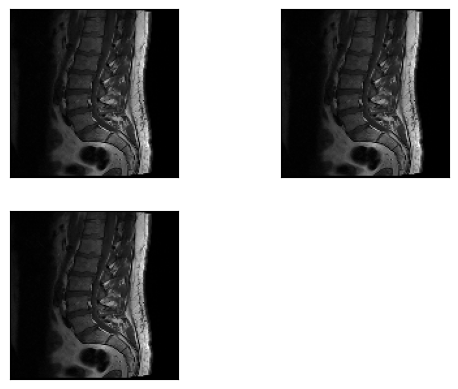

In [38]:
"""ix = 1
for i in range(3):
    print(i)
    for j in range(3):
        print(j)
        ax = plt.subplot(2,2,ix)
        ax.set_xticks([])
        ax.set_yticks([])
        plt.imshow(feature_maps[0,:,:,ix-1], cmap='gray')
        ix += 1
    plt.show()"""

ix = 1
for j in range(3):
    print(j)
    ax = plt.subplot(2,2,ix)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.imshow(feature_maps[0,:,:,ix-1], cmap='gray')
    ix += 1

In [79]:
with tpu_strategy.scope():
    model.evaluate(test_ds)

366/366 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.9060 - loss: 0.3301


In [10]:
with tpu_strategy.scope():
    model.save("keras_base_{0}_{1}.h5".format(condition_for_training, vertebrae_position))

In [11]:
test = keras.models.load_model("/kaggle/working/keras_base_right_neural_foraminal_narrowing_l2_l3.h5")